<font size="5">DATASET</font>
 <br>
https://www.kaggle.com/competitions/deepfake-detection-challenge/data

In [5]:
import numpy as np
import pandas as pd 
import os
import pickle
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
# for dirname, _, filenames in os.walk('./'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

2022-03-11 21:41:57.041714: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dhiraj/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-03-11 21:41:57.041759: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import os
import glob
import time
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face

In [7]:
'''
margin is for including a margin while extracting the face
keep_all: if a frame has more than 1 face it extracts all the faces present in that frame
'''
mtcnn = MTCNN(margin=16, keep_all=True, factor=0.5, device='cpu', post_process=False).eval()

In [8]:
class DetectionPipeline:
  def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
    self.detector = detector
    self.n_frames = n_frames
    self.batch_size = batch_size
    self.resize = resize

  def __call__(self, filename):
    v_cap = cv2.VideoCapture(filename)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if self.n_frames is None:
      sample = np.arange(0, v_len)
    else:
      sample = np.linspace(0, v_len-1, self.n_frames).astype(int)
    
    faces = []
    frames = []
    for j in range(v_len):
      success = v_cap.grab()
      if j in sample:
        # load frame
        success, frame = v_cap.retrieve()
        if not success:
          continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)

        # Resize frame to desired size
        if self.resize is not None:
          frame = frame.resize([int(d*self.resize) for d in frame.size])
        frames.append(frame)

        # when batch is full detect faces and reset frame list
        if len(frames)%self.batch_size==0 or j==sample[-1]:
          faces.extend(self.detector(frames))
          frames = []
    
    v_cap.release()
    return faces

In [9]:
import copy
def process_faces(faces):
  #Filter out frames without faces
  faces = [f for f in faces if f is not None]
  # print(faces[0].shape)
  # print("length = ", len(faces[0]))
  if(len(faces)==0):
    return []
  faces = torch.cat(faces)
#   if(len(faces)<290):
#     print(len(faces))
#     return []
#   faces = faces[:290]
  return faces

In [10]:
detection_pipeline = DetectionPipeline(detector=mtcnn, batch_size=68, resize=0.25, n_frames=25)
import json

with open('./train_sample_videos/metadata.json') as f:
  data = json.load(f)
# Get all test videos
filenames = glob.glob('./train_sample_videos/*.mp4')
total_files = len(filenames)

X = []
y = []
start = time.time()
n_processed = 0

with torch.no_grad():
  for i, filename in tqdm(enumerate(filenames), total=len(filenames)):
    print(i, filename)
    try:
      faces = detection_pipeline(filename)
      z = process_faces(faces)
      if (len(z) != 0):
        X.append(z)
        if(data[filename[22:]]['label']=='FAKE'):
          y.append(1)
        else:
          y.append(0)
    except KeyboardInterrupt:
      print('n\stopped')
      break

    except Exception as e:
      print(e)
      X.append(None)
    
    n_processed += len(faces)

with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)

with open('y.pickle', 'wb') as f:
    pickle.dump(y, f)

  0%|          | 0/400 [00:00<?, ?it/s]

0 ./train_sample_videos/ckkuyewywx.mp4


/home/dhiraj/.local/lib/python3.8/site-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/home/dhiraj/.local/lib/python3.8/site-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/home/dhiraj/.local/lib/python3.8/site-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tup

1 ./train_sample_videos/aklqzsddfl.mp4
2 ./train_sample_videos/brwrlczjvi.mp4
3 ./train_sample_videos/bgaogsjehq.mp4
4 ./train_sample_videos/dqppxmoqdl.mp4
5 ./train_sample_videos/cwwandrkus.mp4
6 ./train_sample_videos/dxuliowugt.mp4
7 ./train_sample_videos/crktehraph.mp4
8 ./train_sample_videos/dulanfulol.mp4
9 ./train_sample_videos/dkuayagnmc.mp4
10 ./train_sample_videos/ddpvuimigj.mp4
11 ./train_sample_videos/etmcruaihe.mp4
12 ./train_sample_videos/eixwxvxbbn.mp4
13 ./train_sample_videos/benmsfzfaz.mp4
14 ./train_sample_videos/caifxvsozs.mp4
15 ./train_sample_videos/ahfazfbntc.mp4
16 ./train_sample_videos/bhbdugnurr.mp4
17 ./train_sample_videos/eepezmygaq.mp4
18 ./train_sample_videos/bqtuuwzdtr.mp4
19 ./train_sample_videos/ddjggcasdw.mp4
20 ./train_sample_videos/asmpfjfzif.mp4
21 ./train_sample_videos/btohlidmru.mp4
22 ./train_sample_videos/cdphtzqrvp.mp4
23 ./train_sample_videos/crezycjqyk.mp4
24 ./train_sample_videos/dnhvalzvrt.mp4
25 ./train_sample_videos/avywawptfc.mp4
26 ./trai

204 ./train_sample_videos/dbhoxkblzx.mp4
205 ./train_sample_videos/dzwkmcwkwl.mp4
206 ./train_sample_videos/duvyaxbzvp.mp4
207 ./train_sample_videos/bchnbulevv.mp4
208 ./train_sample_videos/bntlodcfeg.mp4
209 ./train_sample_videos/dqzreruvje.mp4
210 ./train_sample_videos/caqbrkogkb.mp4
211 ./train_sample_videos/abarnvbtwb.mp4
212 ./train_sample_videos/abofeumbvv.mp4
213 ./train_sample_videos/ddhfabwpuz.mp4
214 ./train_sample_videos/blzydqdfem.mp4
215 ./train_sample_videos/bourlmzsio.mp4
216 ./train_sample_videos/adohikbdaz.mp4
217 ./train_sample_videos/ehtdtkmmli.mp4
218 ./train_sample_videos/byfenovjnf.mp4
219 ./train_sample_videos/duycddgtrl.mp4
220 ./train_sample_videos/axwgcsyphv.mp4
221 ./train_sample_videos/bzythlfnhq.mp4
222 ./train_sample_videos/cttqtsjvgn.mp4
223 ./train_sample_videos/dhcndnuwta.mp4
224 ./train_sample_videos/awhmfnnjih.mp4
225 ./train_sample_videos/awukslzjra.mp4
226 ./train_sample_videos/ejkqesyvam.mp4
227 ./train_sample_videos/dzqwgqewhu.mp4
228 ./train_samp

In [3]:
X = []
y = []
with open('X.pickle', 'rb') as f:
    X = pickle.load(f)
    
with open('y.pickle', 'rb') as f:
    y = pickle.load(f)

/tmp/ipykernel_118410/3365102371.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


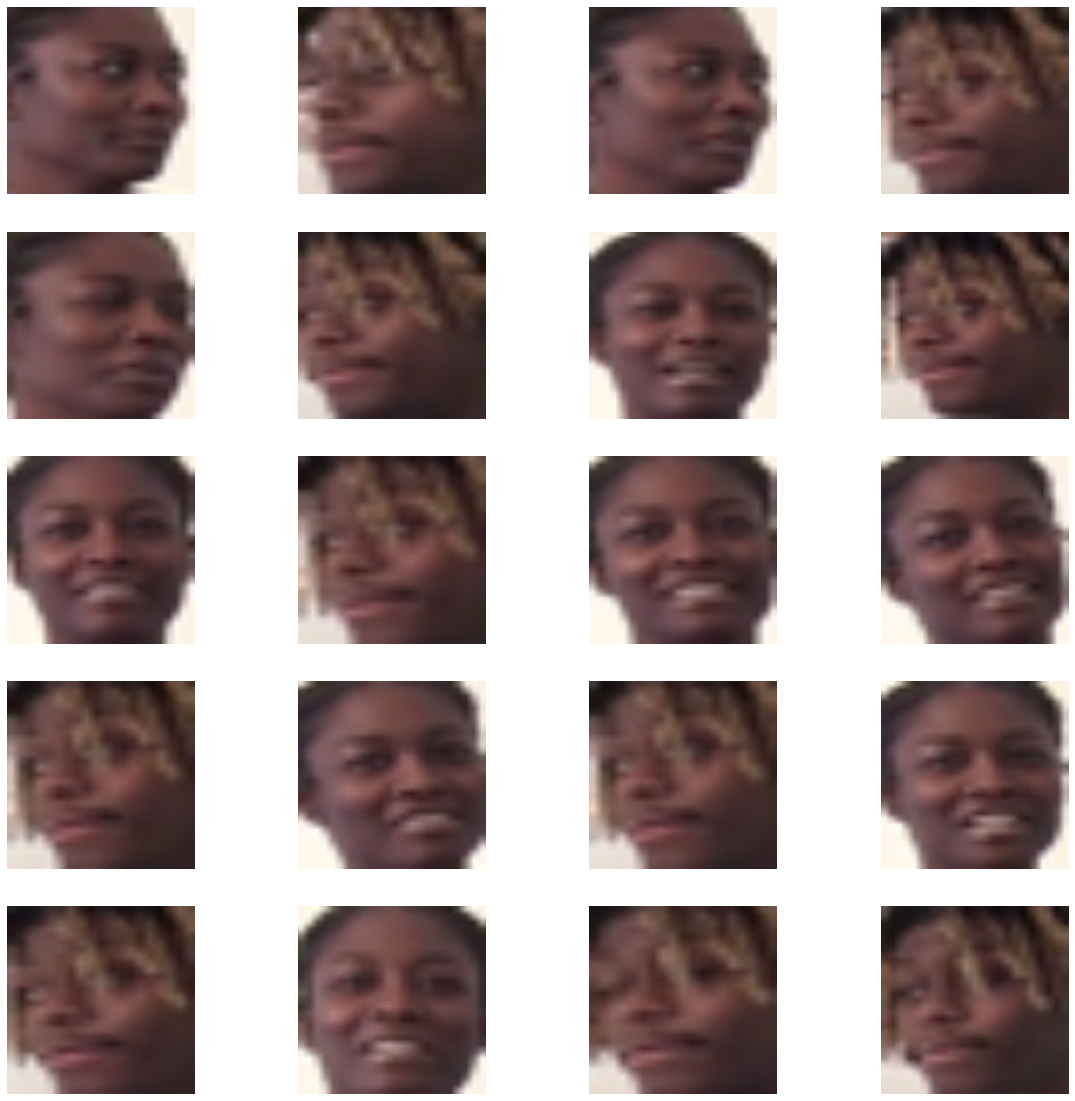

In [4]:
## printing all the faces extracted from the first cideo

fig, axes = plt.subplots(5, 4, figsize=(20,20))
axes = axes.flatten()
for face, ax in zip(X[0][:20], axes):
    ax.imshow(face.permute(1,2,0).int().numpy())
    ax.axis('off')                      
fig.show()

In [11]:
# Data Organisation
total_pictures = 0
dataset = []
labels = []
for ind, faces in enumerate(X):
    for face in faces:
        dataset.append(face)
        labels.append(y[ind])
print(len(dataset))
print(len(labels))

10623
10623


In [12]:
# formating image shape
print(dataset[0].shape)

dataset = [face.permute(1,2,0).int().numpy() for face in dataset]
dataset = np.array(dataset)
labels = np.array(labels)

print(dataset[0].shape)

torch.Size([3, 160, 160])
(160, 160, 3)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.20, random_state=42)

print("X_train : ", len(X_train))
print("y_train : ", len(y_train))
print("X_test : ", len(X_test))
print("y_test : ", len(y_test))

X_train :  8498
y_train :  8498
X_test :  2125
y_test :  2125


In [10]:
count_arr = np.bincount(labels)
print(count_arr[0])
print(count_arr[1])
count_arr

2308
8315


array([2308, 8315])

In [6]:
os.mkdir('./train')
os.mkdir('./train/deepfake')
os.mkdir('./train/normal')
os.mkdir('./test')
os.mkdir('./test/deepfake')
os.mkdir('./test/normal')

In [11]:
'''
Dividing the images into various direstories to use ImageDatagenerator
'''

# for img, label in zip(dataset, labels):
#     pic = np.float32(img)
#     if label == 0:
#         cv2.imwrite(r'./deepfake/%d.jpg'%count, cv2.cvtColor(pic, cv2.COLOR_RGB2BGR))
#     elif label == 1:
#         cv2.imwrite(r'./normal/%d.jpg'%count, cv2.cvtColor(pic, cv2.COLOR_RGB2BGR))
#     count += 1
count = 0

for img, label in zip(X_train, y_train):
    pic = np.float32(img)
    if label == 0:
        cv2.imwrite(r'./train/normal/%d.jpg'%count, cv2.cvtColor(pic, cv2.COLOR_RGB2BGR))
    elif label == 1:
        cv2.imwrite(r'./train/deepfake/%d.jpg'%count, cv2.cvtColor(pic, cv2.COLOR_RGB2BGR))
    count += 1    


for img, label in zip(X_test, y_test):
    pic = np.float32(img)
    if label == 0:
        cv2.imwrite(r'./test/normal/%d.jpg'%count, cv2.cvtColor(pic, cv2.COLOR_RGB2BGR))
    elif label == 1:
        cv2.imwrite(r'./test/deepfake/%d.jpg'%count, cv2.cvtColor(pic, cv2.COLOR_RGB2BGR))
    count += 1

## Data Augmentation ##

In [18]:
# for augmenting the normal faces in the test set, cause the normal faces are a lot lower in number as compared to the deepfaked images
augment = ImageDataGenerator(
    rotation_range = 20,
    fill_mode='nearest',
    horizontal_flip=True,
    zoom_range=0.3,
    brightness_range=[0.6, 1.4],
    width_shift_range=0.2,
    height_shift_range=0.2,
)

normal_test = glob.glob('./test/normal/*.jpg')

for index, filename in enumerate(normal_test):
    img = load_img(filename)
    x = img_to_array(img)
    x = x.reshape((1, ) + x.shape)
    for batch in augment.flow(x, batch_size=1, 
                save_to_dir='./test/normal/',
                save_prefix=f'augment{index}',
                save_format='jpg'):
        break
        

In [6]:
normal_train = glob.glob('./train/normal/*.jpg')

augment = ImageDataGenerator(
    rotation_range = 10,
    fill_mode='nearest',
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.6, 1.4],
    width_shift_range=0.2,
    height_shift_range=0.2,
)

print("Orignal number of normal faces : ", len(normal_train))

for index, filename in enumerate(normal_train):
    img = load_img(filename)
    x = img_to_array(img)
    x = x.reshape((1, ) + x.shape)
    i = 0
    for batch in augment.flow(x, batch_size=1, 
                save_to_dir='./train/normal/',
                save_prefix=f'augment{index}',
                save_format='jpg'):
        i += 1
        if i>=2:
            break
            
normal_train = glob.glob('./train/normal/*.jpg')
print("Number of normal faces after data augmentation : ", len(normal_train))

Orignal number of normal faces :  1818
Number of normal faces after data augmentation :  5454


In [7]:
deepfake_train = glob.glob('./train/deepfake/*.jpg')
print("Number of deepfake faces : ", len(deepfake_train))

Number of deepfake faces :  6680


In [14]:
print(X_train[0].shape)

(160, 160, 3)


## Xception ##

In [13]:
import tensorflow as tf
from tensorflow.keras.applications import Xception, EfficientNetB7
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2

2022-03-10 16:22:32.790322: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dhiraj/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-03-10 16:22:32.790347: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [14]:
xception = Xception(input_shape=X_train[0].shape, weights='imagenet', include_top=False)

for layer in xception.layers:
    layer.trainable = False

regularizer = L2(l2=0.001)

x = Flatten()(xception.output)
prediction = Dense(1024, activation='relu', kernel_regularizer=regularizer)(x)
prediction = Dense(512, activation='relu', kernel_regularizer=regularizer)(prediction)
prediction = Dense(256, activation='relu', kernel_regularizer=regularizer)(prediction)
prediction = Dense(32, activation='relu')(prediction)
prediction = Dense(1, activation='sigmoid')(prediction)

model1 = Model(inputs=xception.input, outputs=prediction)

model1.summary()

2022-03-10 16:22:34.228315: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dhiraj/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-03-10 16:22:34.228337: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-10 16:22:34.228370: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dhiraj-Inspiron-5593): /proc/driver/nvidia/version does not exist
2022-03-10 16:22:34.228528: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 79, 79, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 79, 79, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

2022-03-10 16:22:34.978704: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 209715200 exceeds 10% of free system memory.
2022-03-10 16:22:35.050059: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 209715200 exceeds 10% of free system memory.
2022-03-10 16:22:35.070147: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 209715200 exceeds 10% of free system memory.


In [15]:
model1.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
model1.fit(
    x=X_train,
    y=y_train,
    batch_size=2,
    epochs=10,
    validation_data=(X_test, y_test),    
)

2022-03-10 16:22:40.075681: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 2610585600 exceeds 10% of free system memory.
2022-03-10 16:22:43.192841: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-03-10 16:22:43.761820: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 209715200 exceeds 10% of free system memory.



   1/4249 [..............................] - ETA: 2:43:42 - loss: 3.1324 - accuracy: 1.0000

In [ ]:
model1.save("xception.h5")

In [15]:
from keras.models import load_model

model1 = load_model("xception.h5")

loss, accuracy = model1.evaluate(X_test, y_test)
loss, accuracy

2022-03-10 14:25:13.563233: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


100/100 [==============================] - 103s 1s/step - loss: 0.5358 - accuracy: 0.7741


(0.535799503326416, 0.7740821838378906)

In [16]:
xception = Xception(input_shape=X_train[0].shape, weights='imagenet', include_top=False)

regularizer = L2(l2=0.001)

x = Flatten()(xception.output)
prediction = Dense(1024, activation='relu', kernel_regularizer=regularizer)(x)
prediction = Dense(512, activation='relu', kernel_regularizer=regularizer)(prediction)
prediction = Dense(256, activation='relu')(prediction)
prediction = Dense(32, activation='relu')(prediction)
prediction = Dense(1, activation='sigmoid')(prediction)

model2 = Model(inputs=xception.input, outputs=prediction)

model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 79, 79, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 79, 79, 32)   0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [17]:
model2.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
model2.fit(
    x=X_train,
    y=y_train,
    batch_size=2,
    epochs=10,
    validation_data=(X_test, y_test),    
)

Epoch 1/10
3718/3718 [==============================] - ETA: 0s - loss: 0.6689 - accuracy: 0.7862

In [ ]:
with open('xception_trainable.pickle', 'wb') as f:
    pickle.dump(model2, f)